# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [16]:
!pip install datasets torchmetrics

In [17]:
!pip install wandb

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re

import wandb

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [21]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained

from sklearn.model_selection import train_test_split

text = imdb_dataset['train']['text']
labels = imdb_dataset['train']['label']
test_texts = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']

train_text, val_text, train_labels, val_labels = train_test_split(text, labels, test_size=0.2, random_state=SEED, stratify=labels)

In [23]:
def clean(text, tokenizer):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens

In [24]:
def clean2(text, tokenizer):
    stemmer = PorterStemmer()
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [25]:
clean2("This IS 1 example sentence", RegexpTokenizer(r'\w+'))

['thi', 'is', 'exampl', 'sentenc']

In [26]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx(corpus, minlen=100, maxlen=500, stemming=False):
    word2idx = {}
    idx = 1  # 0 for padding
    tokenizer = RegexpTokenizer(r'\w+')
    for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
        if stemming:
            tokens = clean2(sentence, tokenizer)
        else:
            tokens = clean(sentence, tokenizer)
        
        if not (minlen <= len(tokens) <= maxlen):
            continue
        
        for token in tokens:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
    
    return word2idx

In [27]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500, stemming=False):
        self.inputs = []
        self.targets = []
        self.count = 0
        tokenizer = RegexpTokenizer(r'\w+')
        
        for sentence, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing dataset"):
            if stemming:
                tokens = clean2(sentence, tokenizer)
            else:
                tokens = clean(sentence, tokenizer)
            
            if not (minlen <= len(tokens) <= maxlen):
                continue
            
            indexed_tokens = [word2idx.get(token, 0) for token in tokens] 
            self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
            self.targets.append(label)
            self.count += 1
        
        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)  
        self.targets = torch.tensor(self.targets, dtype=torch.long)
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

In [13]:
word2idx = get_word2idx(train_text, minlen=100, maxlen=500, stemming=False)
print(len(word2idx))

Creating word2idx: 100%|██████████| 20000/20000 [00:03<00:00, 6506.67it/s]

57981


In [14]:
# create the train dataset using the word2idx dictionary built using the train set
# create the validation and test dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(train_text, train_labels, word2idx, minlen=100, maxlen=500, stemming=False)
val_ds = IMDBDataset(val_text, val_labels, word2idx, minlen=100, maxlen=500, stemming=False)
test_ds = IMDBDataset(test_texts, test_labels, word2idx, minlen=100, maxlen=500, stemming=False)

Processing dataset: 100%|██████████| 25000/25000 [00:05<00:00, 4880.46it/s]


In [15]:
len(train_ds), len(val_ds), len(test_ds)

(16048, 4000, 20048)

In [16]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [17]:
# create a model

class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, bidirectional=True, num_layers=1, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        
        # [batch_size, seq_length, embedding_dim]
        embedded = self.dropout(self.embedding(X))
        
        # LSTM output: [batch_size, seq_length, hidden_size * num_directions]
        # Hidden: [num_layers * num_directions, batch_size, hidden_size]
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        logits = self.fc(hidden)
        return logits

In [18]:
# Hyperparameters
vocab_size = len(word2idx) + 1  
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = 2 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes, bidirectional=True, num_layers=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(model)

RNNModel(
  (embedding): Embedding(57982, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [35]:

def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    # initializing wandb
    wandb.init(project='rnn_model')

    best_val_accuracy = 0.0
    best_model = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for input_batch, labels in tqdm(train_loader, total=len(train_loader), desc="Training"):
            input_batch, labels = input_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(input_batch)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0
        accuracy_metric = Accuracy(task="binary").to(device)
        with torch.no_grad():
            for input_batch, labels in tqdm(val_loader, total=len(val_loader), desc="Validation"):
                input_batch, labels = input_batch.to(device), labels.to(device)
                predictions = model(input_batch)
                loss = loss_fn(predictions, labels)
                total_val_loss += loss.item()
                _, predicted_labels = torch.max(predictions, dim=1)
                correct_predictions += (predicted_labels == labels).sum().item()
                total_predictions += labels.size(0)


        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_predictions / total_predictions
        val_accuracies.append(val_accuracy)

        # log metrics to wandb
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_accuracy": val_accuracy})

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f} | Val Accuracy: {val_accuracy*100:.3f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

    wandb.save('model_best.h5')

    return train_losses, val_losses, val_accuracies, best_model

In [36]:
# Create a model testing loop
def test_model(model, test_loader, loss_fn, device):
    model.eval()  
    test_loss = 0
    accuracy_metric = Accuracy(task="binary").to(device)
    correct_predictions = 0
    total_predictions = 0  

    with torch.no_grad():  
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = loss_fn(predictions, labels)
            test_loss += loss.item()
            _, predicted_labels = torch.max(predictions, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {avg_test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")

    return avg_test_loss, test_accuracy


In [21]:

train_losses, val_losses, val_accuracies, best_model = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)

wandb: Currently logged in as: onkarsawant5613. Use `wandb login --relogin` to force relogin


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.69it/s]


Epoch 1/5 | Train Loss: 0.688 | Val Loss: 0.691 | Val Accuracy: 55.500


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.24it/s]


Epoch 2/5 | Train Loss: 0.668 | Val Loss: 0.643 | Val Accuracy: 61.850


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.38it/s]


Epoch 3/5 | Train Loss: 0.596 | Val Loss: 0.651 | Val Accuracy: 68.850


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.41it/s]


Epoch 4/5 | Train Loss: 0.481 | Val Loss: 0.407 | Val Accuracy: 82.050


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.43it/s]

Epoch 5/5 | Train Loss: 0.397 | Val Loss: 0.372 | Val Accuracy: 84.750


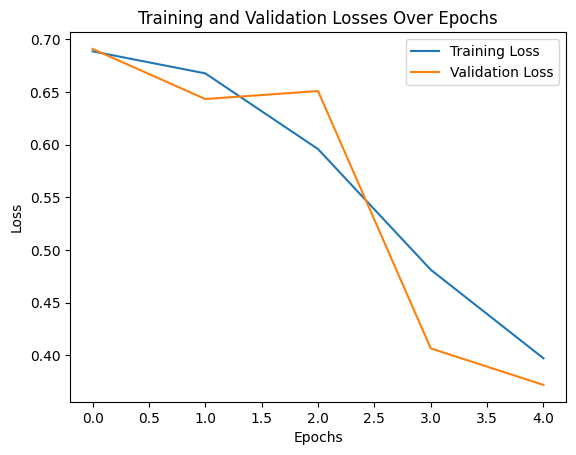

In [22]:
# plot training and validation losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Epochs')
plt.show()

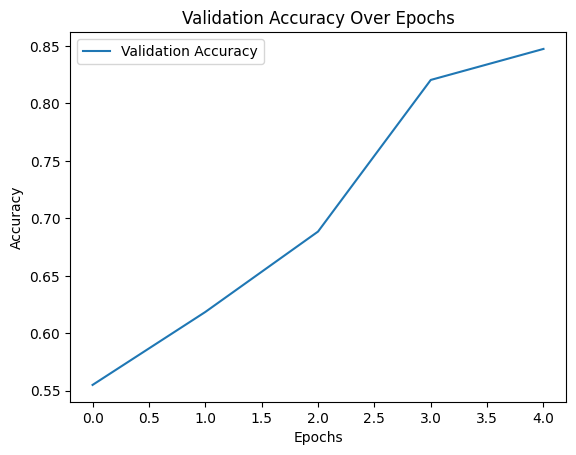

In [23]:
# plot validation accuracy
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.show()

In [24]:
# find the classification accuracy on test set
avg_test_loss, test_accuracy = test_model(model, test_dataloader, criterion, device)

print(f"Average Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy*100:.3f}")

Testing: 100%|██████████| 627/627 [00:30<00:00, 20.81it/s]

Test Loss: 0.398, Test Accuracy: 0.838
Average Test Loss: 0.398
Test Accuracy: 83.799


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [25]:
word2idx_stemmed = get_word2idx(train_text, minlen=100, maxlen=500, stemming=True)


train_ds_stemmed = IMDBDataset(train_text, train_labels, word2idx_stemmed, stemming=True)
val_ds_stemmed = IMDBDataset(val_text, val_labels, word2idx_stemmed, stemming=True)
test_ds_stemmed = IMDBDataset(test_texts, test_labels, word2idx_stemmed, stemming=True)


train_loader_stemmed = DataLoader(train_ds_stemmed, batch_size=32, shuffle=True)
val_loader_stemmed = DataLoader(val_ds_stemmed, batch_size=32)
test_loader_stemmed = DataLoader(test_ds_stemmed, batch_size=32)


model_stemmed = RNNModel(len(word2idx_stemmed)+1, hidden_size, embedding_dim, num_classes,bidirectional=True, num_layers=2).to(device)
optimizer_stemmed = optim.Adam(model_stemmed.parameters(), lr=learning_rate)

train_losses_stemmed, val_losses_stemmed, val_accuracies_stemmed, best_model_stemmed = train_model(model_stemmed, train_loader_stemmed, val_loader_stemmed, optimizer_stemmed, criterion, epochs, device)


Processing dataset: 100%|██████████| 25000/25000 [02:39<00:00, 157.14it/s]


train_loss,█▇▆▃▁
val_accuracy,▁▃▄▇█
val_loss,█▇▇▂▁
train_loss,0.39731
val_accuracy,0.8475
val_loss,0.37206


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.14it/s]


Epoch 1/5 | Train Loss: 0.692 | Val Loss: 0.677 | Val Accuracy: 54.075


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.07it/s]


Epoch 2/5 | Train Loss: 0.688 | Val Loss: 0.685 | Val Accuracy: 53.100


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.96it/s]


Epoch 3/5 | Train Loss: 0.641 | Val Loss: 0.526 | Val Accuracy: 76.175


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.11it/s]


Epoch 4/5 | Train Loss: 0.487 | Val Loss: 0.398 | Val Accuracy: 83.525


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.17it/s]

Epoch 5/5 | Train Loss: 0.381 | Val Loss: 0.442 | Val Accuracy: 81.875


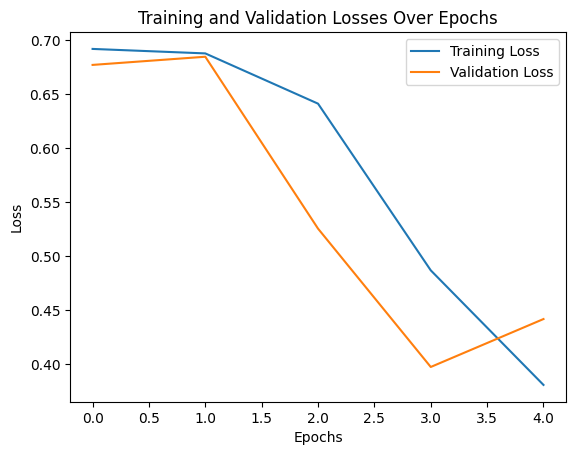

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses_stemmed, label='Training Loss')
plt.plot(val_losses_stemmed, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Epochs')
plt.show()

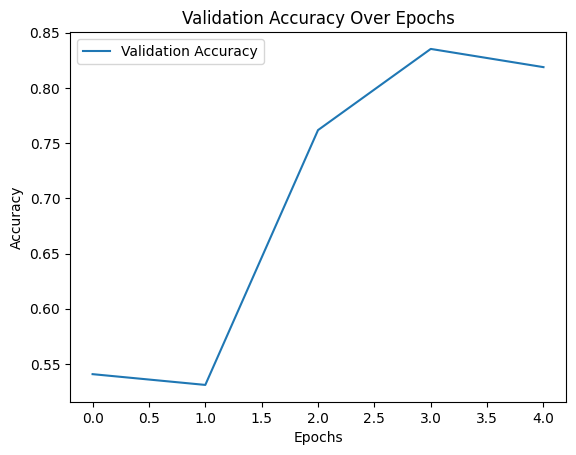

In [27]:
# plot validation accuracy
plt.plot(val_accuracies_stemmed, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.show()

In [28]:
avg_test_loss_stemmed, test_accuracy_stemmed = test_model(model_stemmed, test_loader_stemmed, criterion, device)
print(f"Average Test Loss: {avg_test_loss_stemmed:.3f}")
print(f"Test Accuracy: {test_accuracy_stemmed*100:.3f}")

Testing: 100%|██████████| 627/627 [00:29<00:00, 21.37it/s]

Test Loss: 0.429, Test Accuracy: 0.822
Average Test Loss: 0.429
Test Accuracy: 82.248


### ======================================================================
### Observations

- Increased Test Loss: After applying stemming/lemmatization, the average test loss increased from 0.398 to 0.429.

- Decreased Test Accuracy: The model's accuracy on the test set decreased from 83.799% to 82.248% after incorporating stemming/lemmatization. 

- Processing Time: The processing time for testing the model on the dataset showed a minor improvement, from 30 seconds (20.81 items/sec) to 29 seconds (21.37 items/sec), possibly due to the reduced vocabulary size making the model slightly more efficient to compute.

These observations suggest that while stemming/lemmatization can help in reducing the complexity of the model by reducing the vocabulary size, it may also remove significant semantic information from the text, leading to a slight decrease in model performance in terms of accuracy and loss

### ======================================================================

#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [28]:
class RNNModel_last(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes, output_strategy="last", bidirectional=True, num_layers=2, dropout=0.5):
        super(RNNModel_last, self).__init__()
        self.output_strategy = output_strategy
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, 
                           bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        embedded = self.dropout(self.embedding(X))
        rnn_out, (hidden, cell) = self.rnn(embedded)
        
        if self.output_strategy == "last":
            if self.rnn.bidirectional:
                hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
            else:
                hidden = self.dropout(hidden[-1,:,:])
            output = self.fc(hidden)
        elif self.output_strategy == "mean":
            rnn_out = self.dropout(rnn_out)
            output = torch.mean(rnn_out, dim=1)
            output = self.fc(output)
        else:
            raise ValueError("Invalid output strategy. Choose 'last' or 'mean'.")
        
        return output

In [32]:
word2idx_mean = get_word2idx(train_text, minlen=100, maxlen=500, stemming=False)

train_ds_mean = IMDBDataset(train_text, train_labels, word2idx_mean, stemming=False)
val_ds_mean = IMDBDataset(val_text, val_labels, word2idx_mean, stemming=False)
test_ds_mean = IMDBDataset(test_texts, test_labels, word2idx_mean, stemming=False)

train_loader_mean = DataLoader(train_ds_mean, batch_size=32, shuffle=True)
val_loader_mean = DataLoader(val_ds_mean, batch_size=32)
test_loader_mean = DataLoader(test_ds_mean, batch_size=32)

model_mean = RNNModel_last(len(word2idx_mean)+1, hidden_size, embedding_dim, num_classes,output_strategy="mean", bidirectional=True, num_layers=2).to(device)
optimizer_mean = optim.Adam(model_mean.parameters(), lr=learning_rate)

train_losses_mean, val_losses_mean, val_accuracies_mean, best_model_mean = train_model(model_mean, train_loader_mean, val_loader_mean, optimizer_mean, criterion, epochs, device)

Processing dataset: 100%|██████████| 25000/25000 [00:05<00:00, 4992.17it/s]


train_loss,██▇▃▁
val_accuracy,▁▁▆██
val_loss,██▄▁▂
train_loss,0.38091
val_accuracy,0.81875
val_loss,0.4419


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.55it/s]


Epoch 1/5 | Train Loss: 0.632 | Val Loss: 0.467 | Val Accuracy: 78.550


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.41it/s]


Epoch 2/5 | Train Loss: 0.399 | Val Loss: 0.345 | Val Accuracy: 86.550


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.47it/s]


Epoch 3/5 | Train Loss: 0.295 | Val Loss: 0.307 | Val Accuracy: 87.600


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.48it/s]


Epoch 4/5 | Train Loss: 0.245 | Val Loss: 0.305 | Val Accuracy: 88.700


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.38it/s]

Epoch 5/5 | Train Loss: 0.202 | Val Loss: 0.317 | Val Accuracy: 89.000


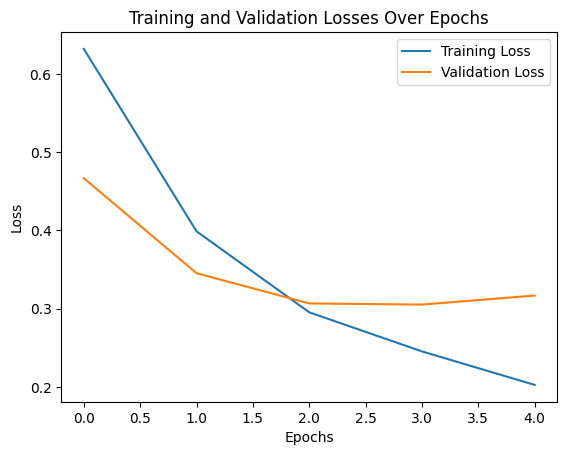

In [33]:
# plot training and validation losses
import matplotlib.pyplot as plt

plt.plot(train_losses_mean, label='Training Loss')
plt.plot(val_losses_mean, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Epochs')
plt.show()

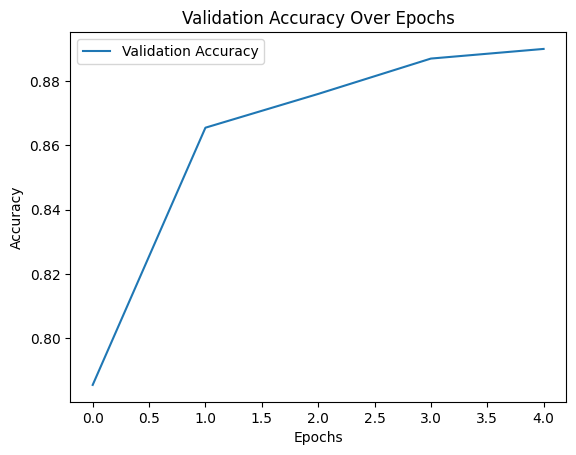

In [34]:
# plot validation accuracy
plt.plot(val_accuracies_mean, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.show()

In [35]:
avg_test_loss_mean, test_accuracy_mean = test_model(model_mean, test_loader_mean, criterion, device)
print(f"Average Test Loss: {avg_test_loss_mean:.3f}")
print(f"Test Accuracy: {test_accuracy_mean*100:.3f}")

Testing: 100%|██████████| 627/627 [00:28<00:00, 21.83it/s]

Test Loss: 0.307, Test Accuracy: 0.890
Average Test Loss: 0.307
Test Accuracy: 89.041


### ======================================================================
### Observations
- Improvement in Accuracy: Switching from the last output to the mean of all outputs resulted in a significant increase in test accuracy from 83.799% to 89.041%.

- Reduction in Test Loss: There was a noticeable reduction in the average test loss from 0.398 to 0.307 when using the mean of all outputs instead of just the last output.

- Faster Inference Time: The processing time during the testing phase slightly improved, as seen in the progress bar's completion times (from 30 seconds at 20.81 items/second to 28 seconds at 21.83 items/second). While the difference is not huge.

These observations suggest that for the specific task of sentiment analysis on the IMDB Movie Review Dataset, utilizing the mean of all outputs from the RNN layer offers a more effective approach than relying solely on the last output, leading improvements in both model accuracy and loss
### ======================================================================

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [36]:
hyperparameter_configs = [
    {"embedding_dim": 128, "hidden_size": 256, "batch_size": 64},
    {"embedding_dim": 128, "hidden_size": 512, "batch_size": 32},
    {"embedding_dim": 256, "hidden_size": 256, "batch_size": 64},
    {"embedding_dim": 256, "hidden_size": 512, "batch_size": 32},
    {"embedding_dim": 100, "hidden_size": 256, "batch_size": 32}
]

def train_and_evaluate(config):
    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False)
    
    model = RNNModel_last(vocab_size, config["hidden_size"], config["embedding_dim"], num_classes, output_strategy="last", bidirectional=True, num_layers=2).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, val_accuracies, _ = train_model(model, train_loader, val_loader, optimizer, criterion, 5, device)
    best_val_accuracy = max(val_accuracies)
    return best_val_accuracy, config

best_accuracy = 0
best_config = None

for config in hyperparameter_configs:
    print(f"Training with config: {config}")
    val_accuracy, current_config = train_and_evaluate(config)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_config = current_config
    print(f"Validation Accuracy: {val_accuracy*100:.3f}\n")


print(f"Best Configuration: {best_config} with Validation Accuracy: {best_accuracy*100:.3f}")


Training with config: {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 64}


train_loss,█▄▃▂▁
val_accuracy,▁▆▇██
val_loss,█▃▁▁▁
train_loss,0.20248
val_accuracy,0.89
val_loss,0.31668


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.87it/s]


Epoch 1/5 | Train Loss: 0.680 | Val Loss: 0.697 | Val Accuracy: 52.300


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.47it/s]


Epoch 2/5 | Train Loss: 0.676 | Val Loss: 0.618 | Val Accuracy: 66.525


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.92it/s]


Epoch 3/5 | Train Loss: 0.659 | Val Loss: 0.689 | Val Accuracy: 51.650


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.79it/s]


Epoch 4/5 | Train Loss: 0.667 | Val Loss: 0.625 | Val Accuracy: 65.600


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.43it/s]


Epoch 5/5 | Train Loss: 0.601 | Val Loss: 0.588 | Val Accuracy: 70.675
Validation Accuracy: 70.675

Training with config: {'embedding_dim': 128, 'hidden_size': 512, 'batch_size': 32}


train_loss,██▆▇▁
val_accuracy,▁▆▁▆█
val_loss,█▃█▃▁
train_loss,0.60054
val_accuracy,0.70675
val_loss,0.58759


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.43it/s]


Epoch 1/5 | Train Loss: 0.686 | Val Loss: 0.669 | Val Accuracy: 59.900


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.46it/s]


Epoch 2/5 | Train Loss: 0.661 | Val Loss: 0.693 | Val Accuracy: 49.125


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.56it/s]


Epoch 3/5 | Train Loss: 0.678 | Val Loss: 0.688 | Val Accuracy: 52.600


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.58it/s]


Epoch 4/5 | Train Loss: 0.586 | Val Loss: 0.491 | Val Accuracy: 76.550


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.59it/s]


Epoch 5/5 | Train Loss: 0.443 | Val Loss: 0.406 | Val Accuracy: 81.475
Validation Accuracy: 81.475

Training with config: {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}


train_loss,█▇█▅▁
val_accuracy,▃▁▂▇█
val_loss,▇██▃▁
train_loss,0.44282
val_accuracy,0.81475
val_loss,0.40631


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.12it/s]


Epoch 1/5 | Train Loss: 0.685 | Val Loss: 0.694 | Val Accuracy: 51.000


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.52it/s]


Epoch 2/5 | Train Loss: 0.681 | Val Loss: 0.624 | Val Accuracy: 64.175


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.43it/s]


Epoch 3/5 | Train Loss: 0.585 | Val Loss: 0.428 | Val Accuracy: 80.350


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.98it/s]


Epoch 4/5 | Train Loss: 0.414 | Val Loss: 0.402 | Val Accuracy: 82.250


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.56it/s]


Epoch 5/5 | Train Loss: 0.332 | Val Loss: 0.309 | Val Accuracy: 87.700
Validation Accuracy: 87.700

Training with config: {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 32}


train_loss,██▆▃▁
val_accuracy,▁▄▇▇█
val_loss,█▇▃▃▁
train_loss,0.33161
val_accuracy,0.877
val_loss,0.30941


Validation: 100%|██████████| 125/125 [00:12<00:00, 10.23it/s]


Epoch 1/5 | Train Loss: 0.698 | Val Loss: 0.694 | Val Accuracy: 51.025


Validation: 100%|██████████| 125/125 [00:12<00:00, 10.31it/s]


Epoch 2/5 | Train Loss: 0.690 | Val Loss: 0.729 | Val Accuracy: 51.050


Validation: 100%|██████████| 125/125 [00:12<00:00, 10.19it/s]


Epoch 3/5 | Train Loss: 0.684 | Val Loss: 0.712 | Val Accuracy: 52.475


Validation: 100%|██████████| 125/125 [00:12<00:00, 10.16it/s]


Epoch 4/5 | Train Loss: 0.541 | Val Loss: 0.457 | Val Accuracy: 80.100


Validation: 100%|██████████| 125/125 [00:12<00:00, 10.19it/s]


Epoch 5/5 | Train Loss: 0.403 | Val Loss: 0.359 | Val Accuracy: 84.525
Validation Accuracy: 84.525

Training with config: {'embedding_dim': 100, 'hidden_size': 256, 'batch_size': 32}


train_loss,███▄▁
val_accuracy,▁▁▁▇█
val_loss,▇██▃▁
train_loss,0.40289
val_accuracy,0.84525
val_loss,0.35884


Validation: 100%|██████████| 125/125 [00:05<00:00, 22.05it/s]


Epoch 1/5 | Train Loss: 0.683 | Val Loss: 0.643 | Val Accuracy: 63.675


Validation: 100%|██████████| 125/125 [00:05<00:00, 22.05it/s]


Epoch 2/5 | Train Loss: 0.691 | Val Loss: 0.691 | Val Accuracy: 52.850


Validation: 100%|██████████| 125/125 [00:05<00:00, 22.02it/s]


Epoch 3/5 | Train Loss: 0.662 | Val Loss: 0.667 | Val Accuracy: 61.875


Validation: 100%|██████████| 125/125 [00:05<00:00, 21.93it/s]


Epoch 4/5 | Train Loss: 0.604 | Val Loss: 0.572 | Val Accuracy: 72.750


Validation: 100%|██████████| 125/125 [00:05<00:00, 21.86it/s]

Epoch 5/5 | Train Loss: 0.483 | Val Loss: 0.391 | Val Accuracy: 82.975
Validation Accuracy: 82.975

Best Configuration: {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64} with Validation Accuracy: 87.700


### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size_lstm, hidden_size_lstm, embedding_dim_lstm, num_classes_lstm, output_strategy_lstm="mean", bidirectional=True, num_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size_lstm, embedding_dim_lstm)
        self.lstm = nn.LSTM(embedding_dim_lstm, hidden_size_lstm, num_layers=num_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.output_strategy_lstm = output_strategy_lstm
        self.fc = nn.Linear(hidden_size_lstm * 2 if bidirectional else hidden_size_lstm, num_classes_lstm)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        embedded = self.dropout(self.embedding(X))
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        if self.output_strategy_lstm == "last":
            if self.lstm.bidirectional:
                hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
            else:
                hidden = self.dropout(hidden[-1,:,:])
            output = self.fc(hidden)
        elif self.output_strategy_lstm == "mean":
            lstm_out = self.dropout(lstm_out)
            output = torch.mean(lstm_out, dim=1)
            output = self.fc(output)
        else:
            raise ValueError("Invalid output strategy. Choose 'last' or 'mean'.")
        
        return output

In [38]:

use_stemming = False  

word2idx = get_word2idx(train_text, stemming=use_stemming)
train_ds = IMDBDataset(train_text, train_labels, word2idx, stemming=use_stemming)
val_ds = IMDBDataset(val_text, val_labels, word2idx, stemming=use_stemming)
test_ds = IMDBDataset(test_texts, test_labels, word2idx, stemming=use_stemming)


Processing dataset: 100%|██████████| 25000/25000 [00:05<00:00, 4940.31it/s]


In [39]:
vocab_size_lstm = len(word2idx) + 1 
num_classes_lstm = 2
learning_rate_lstm = 1e-3
device_lstm = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_strategy = "mean"
use_stemming = False

print(f"Running LSTM model with output strategy '{output_strategy}' and stemming {'enabled' if use_stemming else 'disabled'}")

batch_size_lstm = best_config["batch_size"]
train_loader_lstm = DataLoader(train_ds, batch_size=batch_size_lstm, shuffle=True)
val_loader_lstm = DataLoader(val_ds, batch_size=batch_size_lstm, shuffle=False)

model_lstm = LSTMModel(vocab_size_lstm, best_config["hidden_size"], best_config["embedding_dim"], num_classes_lstm, output_strategy, bidirectional=True, num_layers=2).to(device_lstm)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate_lstm)
criterion_lstm = nn.CrossEntropyLoss()

train_losses_lstm, val_losses_lstm, val_accuracies_lstm, _ = train_model(model_lstm, train_loader_lstm, val_loader_lstm, optimizer_lstm, criterion_lstm, 5, device_lstm)
print(f"Validation Accuracy: {max(val_accuracies_lstm)*100:.3f}%\n")

Running LSTM model with output strategy 'mean' and stemming disabled


train_loss,██▇▅▁
val_accuracy,▄▁▃▆█
val_loss,▇█▇▅▁
train_loss,0.48316
val_accuracy,0.82975
val_loss,0.39111


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.52it/s]


Epoch 1/5 | Train Loss: 0.578 | Val Loss: 0.411 | Val Accuracy: 81.975


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.04it/s]


Epoch 2/5 | Train Loss: 0.368 | Val Loss: 0.312 | Val Accuracy: 86.825


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.47it/s]


Epoch 3/5 | Train Loss: 0.277 | Val Loss: 0.311 | Val Accuracy: 88.275


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.06it/s]


Epoch 4/5 | Train Loss: 0.226 | Val Loss: 0.312 | Val Accuracy: 88.650


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.50it/s]

Epoch 5/5 | Train Loss: 0.186 | Val Loss: 0.295 | Val Accuracy: 89.575
Validation Accuracy: 89.575%



In [40]:
def test_model_lstm(model, test_loader, criterion, device):
    model.eval()  
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            _, predicted_labels = torch.max(predictions, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {avg_test_loss:.3f}, Test Accuracy: {test_accuracy*100:.3f}")

test_loader_lstm = DataLoader(test_ds, batch_size=best_config["batch_size"], shuffle=False)
criterion_lstm = nn.CrossEntropyLoss()
test_model_lstm(model_lstm, test_loader_lstm, criterion_lstm, device_lstm)

Testing: 100%|██████████| 314/314 [00:23<00:00, 13.42it/s]

Test Loss: 0.313, Test Accuracy: 88.747


### equivalant RNN

In [31]:
best_config = {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 64}

In [38]:
word2idx_mean = get_word2idx(train_text, minlen=100, maxlen=500, stemming=False)

train_ds_mean = IMDBDataset(train_text, train_labels, word2idx_mean, stemming=False)
val_ds_mean = IMDBDataset(val_text, val_labels, word2idx_mean, stemming=False)
test_ds_mean = IMDBDataset(test_texts, test_labels, word2idx_mean, stemming=False)

train_loader_mean = DataLoader(train_ds_mean, batch_size=best_config["batch_size"], shuffle=True)
val_loader_mean = DataLoader(val_ds_mean, batch_size=best_config["batch_size"])
test_loader_mean = DataLoader(test_ds_mean, batch_size=best_config["batch_size"])

model_mean = RNNModel_last(len(word2idx_mean)+1, best_config["hidden_size"], best_config["embedding_dim"], 2,output_strategy="mean", bidirectional=True, num_layers=2).to(device)
optimizer_mean = optim.Adam(model_mean.parameters(), lr=1e-3)

train_losses_mean, val_losses_mean, val_accuracies_mean, best_model_mean = train_model(model_mean, train_loader_mean, val_loader_mean, optimizer_mean, nn.CrossEntropyLoss(), 5, device)

Processing dataset: 100%|██████████| 25000/25000 [00:05<00:00, 4871.95it/s]
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.41it/s]


Epoch 1/5 | Train Loss: 0.566 | Val Loss: 0.396 | Val Accuracy: 82.500


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.65it/s]


Epoch 2/5 | Train Loss: 0.369 | Val Loss: 0.320 | Val Accuracy: 87.425


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.23it/s]


Epoch 3/5 | Train Loss: 0.283 | Val Loss: 0.317 | Val Accuracy: 87.975


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.51it/s]


Epoch 4/5 | Train Loss: 0.224 | Val Loss: 0.300 | Val Accuracy: 88.675


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.19it/s]

Epoch 5/5 | Train Loss: 0.181 | Val Loss: 0.331 | Val Accuracy: 89.300


In [39]:
avg_test_loss_mean, test_accuracy_mean = test_model(model_mean, test_loader_mean, nn.CrossEntropyLoss(), device)
print(f"Average Test Loss: {avg_test_loss_mean:.3f}")
print(f"Test Accuracy: {test_accuracy_mean*100:.3f}")

Testing: 100%|██████████| 314/314 [00:23<00:00, 13.13it/s]

Test Loss: 0.337, Test Accuracy: 0.892
Average Test Loss: 0.337
Test Accuracy: 89.186


## Conclusion

- Improvement in Test Loss: The test loss decreased from 0.337 to 0.313 when switching from RNN to LSTM. This indicates that the LSTM model was better at minimizing the prediction error on unseen data.

- Slight Decrease in Test Accuracy: Test accuracy slightly decreased from 89.186% to 88.747%. Although this might seem counterintuitive given the reduced loss, it suggests that the LSTM model's predictions were more confident (contributing to lower loss) but not always more accurate.

- Trade-off Between Loss and Accuracy: The observed changes highlight a common trade-off in machine learning models where reducing the loss does not always lead to higher accuracy. The decrease in loss suggests better confidence in predictions, which might be due to the LSTM's ability to utilize long-term dependencies more effectively.

Overall, replacing RNN with LSTM showed a nuanced impact on model performance, demonstrating improved loss indicating better overall prediction confidence, despite a marginal decrease in accuracy.